# How to transform data into factors
Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones.

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our data folder to facilitate reuse in later chapters.

## Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!conda list | grep pandas_datareader

In [4]:
%matplotlib inline

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pyfinance.ols import PandasRollingOLS # pyfinance version: 0.1.3
import json

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

# Get Data
The assets.h5 store can be generated using the the notebook create_datasets in the data directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using pd.IndexSlice to perform a slice operation on the pd.MultiIndex, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:


In [6]:
DATA_STORE = '../data/assets.h5'
START = 2000
END = 2018

In [28]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.info())
    print(store['quandl/wiki/prices'].info())
    print(store['sp500/fred'].info())
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]
#     

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/quandl/wiki/prices            frame        (shape->[15389314,12])
/quandl/wiki/stocks            frame        (shape->[1,2])        
/sp500/fred                    frame        (shape->[2610,1])     
/us_equities/stocks            frame        (shape->[6834,6])     
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   open         float64
 1   high         float64
 2   low          float64
 3   close        float64
 4   volume       float64
 5   ex-dividend  float64
 6   split_ratio  float64
 7   adj_open     float64
 8   adj_high     float64
 9   adj_low      float64
 10  adj_close    float64
 11  adj_volume   float64
dtypes: float64(12)
memory usage: 1.4+ GB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entrie

In [23]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [27]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


## Keep data with stock info
Remove stocks duplicates and align index names for later joining.

In [30]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

,marketcap,ipoyear,sector
ticker,,,
PIH,4.309000e+07,2014.0,Finance
PIHPP,NaN,NaN,Finance
TURN,7.033000e+07,NaN,Finance
FLWS,8.333900e+08,1999.0,Consumer Services
FCCY,1.781400e+08,NaN,Finance
...,...,...,...
ZOES,1.974000e+08,2014.0,Consumer Services
ZTS,4.165000e+10,2013.0,Health Care
ZTO,1.434000e+10,2016.0,Transportation


In [31]:
# Get tickers with both price information and metdata
shared = prices.columns.intersection(stocks.index)

In [33]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


In [35]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [36]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series
To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [37]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(n_periods), that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the .stack() method, use .pipe() to apply the .clip() method to the resulting DataFrame, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using .swaplevel() to change the order of the MultiIndex levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [39]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


In [40]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 399525 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   399525 non-null  float64
 1   return_2m   399525 non-null  float64
 2   return_3m   399525 non-null  float64
 3   return_6m   399525 non-null  float64
 4   return_9m   399525 non-null  float64
 5   return_12m  399525 non-null  float64
dtypes: float64(6)
memory usage: 19.9+ MB


# Drop stocks with less than 10 yrs of returns

In [41]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [42]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


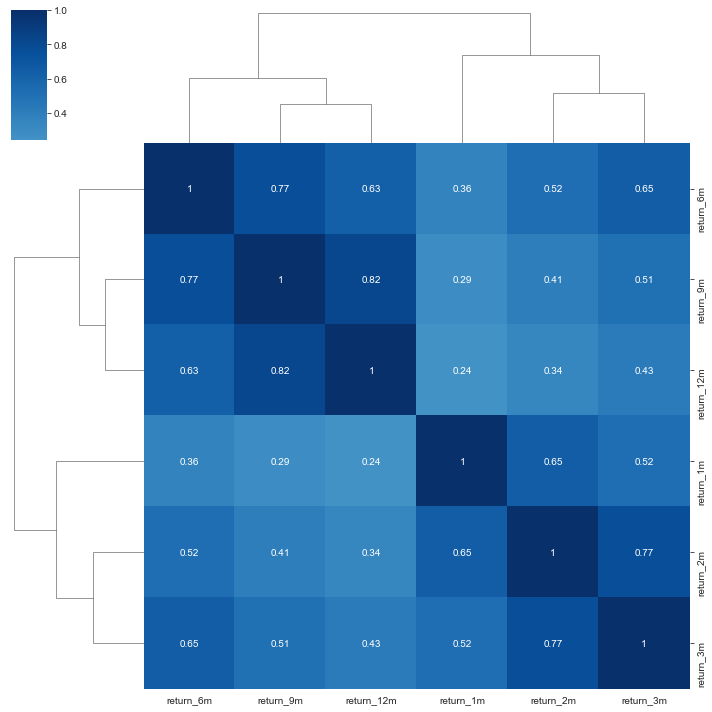

In [43]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [44]:
data.index.get_level_values('ticker').nunique()

1838

# Rolling Factor Betas
We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in Chapter 9, Time Series Models.

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the PandasRollingOLS rolling linear regression functionality in the pyfinance library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [45]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-31 to 2020-12-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  252 non-null    float64
 1   SMB     252 non-null    float64
 2   HML     252 non-null    float64
 3   RMW     252 non-null    float64
 4   CMA     252 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB


In [46]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     360752 non-null  float64
 1   SMB        360752 non-null  float64
 2   HML        360752 non-null  float64
 3   RMW        360752 non-null  float64
 4   CMA        360752 non-null  float64
 5   return_1m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [47]:

T = 24
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [48]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000,318478.000000
mean,0.981852,0.628170,0.128163,-0.059209,0.013730,1.692706
std,0.918801,1.248064,1.615946,1.919871,2.182699,3.454764
min,-9.922641,-10.212033,-17.654894,-22.925165,-18.182706,-31.429456
25%,0.465436,-0.114603,-0.710337,-0.979134,-1.086916,-0.088592
50%,0.932070,0.543000,0.101905,0.039257,0.032829,1.632188
75%,1.447382,1.303498,0.955347,0.955350,1.140405,3.456170
max,10.916430,10.373043,14.558920,17.413382,17.626042,33.316296


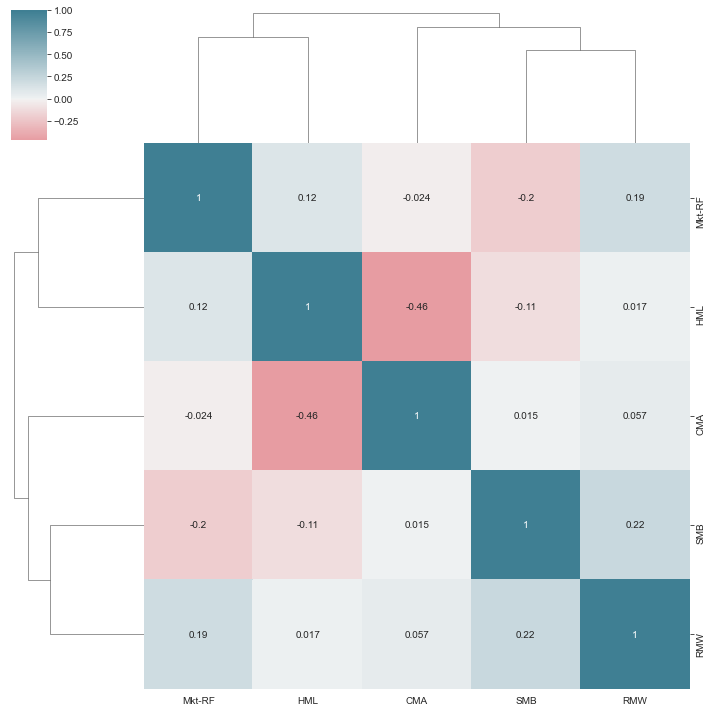

In [49]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [50]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      316640 non-null  float64
 7   SMB         316640 non-null  float64
 8   HML         316640 non-null  float64
 9   RMW         316640 non-null  float64
 10  CMA         316640 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


## Impute mean for missing factor betas

In [51]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


# Momentum factors
We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [52]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

# Data Indicators

In [53]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

# Lagged returns
To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [55]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

In [64]:
data_peak = data.groupby(level="ticker")

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-02-28   -0.084537  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-03-31   -0.096606  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-04-30   -0.066102  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-05-31   -0.063425  1.279902  0.602331 -0.655264 -1.225707  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.781969  0.990484  1.404749  2.912727  ...   
       2017-12-31   -0.003996 -0.783506  1.329358  1.363575  3.413242  ...   
       2018-01-31    0.002864 -0.956662  1.647923  1.546264  3.586415  ...   
       2018-02-28   -0.002905  0.102510  1.172206  1.323166  2.922154  ...   
       2018-03-31    0.021422  0.376489  1.034578  1.356986  2.652526  ...   

                   momentum_12  momentum_3_12  year  month  return_1m_t-1  \
ticker date                                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1            NaN   
       2001-02-28     0.245026       0.031898  2001      2      -0.003653   
       2001-03-31     0.049783       0.078511  2001      3      -0.329564   
       2001-04-30    -0.335545       0.039645  2001      4      -0.146389   
       2001-05-31     0.076795      -0.040108  2001      5       0.269444   
...                        ...            ...   ...    ...            ...   
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11      -0.024862   
       2017-12-31     0.040729      -0.051853  2017     12       0.235127   
       2018-01-31     0.006465      -0.052554  2018      1      -0.044725   
       2018-02-28     0.047697       0.030295  2018      2      -0.003601   
       2018-03-31    -0.176548      -0.021157  2018      3      -0.050602   

                   return_1m_t-2  return_1m_t-3  return_1m_t-4  return_1m_t-5  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31      -0.003653            NaN            NaN            NaN   
       2001-04-30      -0.329564      -0.003653            NaN            NaN   
       2001-05-31      -0.146389      -0.329564      -0.003653            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30       0.430943      -0.019685       0.028340      -0.133333   
       2017-12-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-01-31       0.235127      -0.024862       0.430943      -0.019685   
       2018-02-28      -0.044725       0.235127      -0.024862       0.430943   
       2018-03-31      -0.003601      -0.

# Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [65]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [66]:

cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

# Create age proxy
We use quintles of IPO year as a proxy for company age.

In [68]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')
             )
       )
data.age = data.age.fillna(-1)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  ...  \
ticker date                                                            ...   
A      2001-01-31   -0.015988  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-02-28   -0.084537  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-03-31   -0.096606  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-04-30   -0.066102  1.279902  0.602331 -0.655264 -1.225707  ...   
       2001-05-31   -0.063425  1.279902  0.602331 -0.655264 -1.225707  ...   
...                       ...       ...       ...       ...       ...  ...   
ZUMZ   2017-11-30   -0.010687 -0.781969  0.990484  1.404749  2.912727  ...   
       2017-12-31   -0.003996 -0.783506  1.329358  1.363575  3.413242  ...   
       2018-01-31    0.002864 -0.956662  1.647923  1.546264  3.586415  ...   
       2018-02-28   -0.002905  0.102510  1.172206  1.323166  2.922154  ...   
       2018-03-31    0.021422  0.376489  1.034578  1.356986  2.652526  ...   

                   return_1m_t-3  return_1m_t-4  return_1m_t-5  return_1m_t-6  \
ticker date                                                                     
A      2001-01-31            NaN            NaN            NaN            NaN   
       2001-02-28            NaN            NaN            NaN            NaN   
       2001-03-31            NaN            NaN            NaN            NaN   
       2001-04-30      -0.003653            NaN            NaN            NaN   
       2001-05-31      -0.329564      -0.003653            NaN            NaN   
...                          ...            ...            ...            ...   
ZUMZ   2017-11-30      -0.019685       0.028340      -0.133333      -0.206128   
       2017-12-31       0.430943      -0.019685       0.028340      -0.133333   
       2018-01-31      -0.024862       0.430943      -0.019685       0.028340   
       2018-02-28       0.235127      -0.024862       0.430943      -0.019685   
       2018-03-31      -0.044725       0.235127      -0.024862       0.430943   

                   target_1m  target_2m  target_3m  target_6m  target_12m  age  
ticker date                                                                     
A      2001-01-31  -0.329564  -0.249443  -0.105747  -0.101978   -0.047686    2  
       2001-02-28  -0.146389   0.040966  -0.023317  -0.049781   -0.011986    2  
       2001-03-31   0.269444   0.044721   0.018842  -0.072607    0.010805    2  
       2001-04-30  -0.140220  -0.087246  -0.098192  -0.089198   -0.021512    2  
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.033904   -0.019843    2  
...                      ...        ...        ...        ...         ...  ...  
ZUMZ   2017-11-30  -0.044725  -0.024380  -0.033200        NaN         NaN    3  
       2017-12-31  -0.003601  -0.027386   0.042579        NaN         NaN    3  
       2018-01-31  -0.050602   0.066466        NaN        NaN         NaN    3  
       2018-02-28   0.197970        NaN        NaN        NaN         

# Create dynamic size proxy
We use the markeycap information from the NASQAQ ticker info to create a size proxy.

In [70]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [72]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-02-28,1.023731,1.065815,1.017393,0.967105,0.993392,1.058097,1.030483,0.955842,1.132722,1.012381,...,0.912338,1.024677,0.970196,1.071626,1.019784,1.112593,1.056709,0.920988,0.922551,0.834746
2018-01-31,1.095970,1.067191,0.900264,0.957895,1.017216,0.994594,0.952583,1.027240,1.186406,1.020000,...,1.027597,1.876616,1.008464,1.171829,0.909198,1.151111,1.038639,0.974074,0.963554,0.879237
2017-12-31,0.999552,1.022200,0.877367,0.965789,0.866794,1.005287,0.993226,0.709964,1.092965,0.918095,...,1.100649,1.689777,0.972938,1.112371,0.766278,1.061235,0.977124,1.022222,0.997722,0.882415
2017-11-30,1.033433,0.991945,0.830471,0.959211,0.878185,1.020851,0.977985,0.698781,1.009642,0.944762,...,1.206169,1.447709,0.995112,1.079462,0.814410,0.983704,0.952518,1.128395,1.002278,0.923729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,0.341528,1.072518,0.099870,0.044896,0.118576,0.007615,0.585097,0.081291,0.143071,0.133726,...,0.159492,16303.937720,0.071803,0.250196,0.147743,0.184687,0.842713,3.950617,2.211845,0.543008
2001-04-30,0.397227,1.072518,0.098187,0.037997,0.118576,0.009730,0.585097,0.063871,0.133873,0.130464,...,0.156495,15593.955347,0.070420,0.250196,0.141936,0.116861,0.826400,3.950617,2.842825,0.543008
2001-03-31,0.312914,1.072518,0.096628,0.038757,0.118576,0.008424,0.585097,0.067936,0.121602,0.133959,...,0.161490,14648.737955,0.060003,0.250196,0.125105,0.106000,0.807791,3.950617,1.601595,0.543008


In [74]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')
msize

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YORW,YRCW,YUM,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2018-03-31,1.960000e+10,1.767000e+10,3.200000e+09,1.810000e+09,9.990000e+09,9.039900e+11,1.830000e+09,1.900000e+09,1.905000e+10,2.160000e+09,...,4.268100e+08,3.429500e+08,2.516000e+10,2.275000e+10,7.920000e+09,2.295400e+08,1.032000e+10,4.357400e+08,2.944800e+08,6.316500e+08
2018-02-28,2.006513e+10,1.883296e+10,3.255658e+09,1.750461e+09,9.923985e+09,9.565088e+11,1.885783e+09,1.816100e+09,2.157836e+10,2.186743e+09,...,3.893948e+08,3.514129e+08,2.441012e+10,2.437949e+10,8.076693e+09,2.553845e+08,1.090524e+10,4.013112e+08,2.716729e+08,5.272672e+08
2018-01-31,2.148101e+10,1.885726e+10,2.880845e+09,1.733789e+09,1.016199e+10,8.991033e+11,1.743226e+09,1.951756e+09,2.260104e+10,2.203200e+09,...,4.385888e+08,6.435854e+08,2.537297e+10,2.665911e+10,7.200850e+09,2.642260e+08,1.071875e+10,4.244430e+08,2.837472e+08,5.553702e+08
2017-12-31,1.959122e+10,1.806228e+10,2.807574e+09,1.748079e+09,8.659274e+09,9.087693e+11,1.817604e+09,1.348932e+09,2.082099e+10,1.983086e+09,...,4.697681e+08,5.795089e+08,2.447911e+10,2.530644e+10,6.068921e+09,2.435958e+08,1.008392e+10,4.454231e+08,2.938092e+08,5.573776e+08
2017-11-30,2.025528e+10,1.752767e+10,2.657508e+09,1.736171e+09,8.773063e+09,9.228388e+11,1.789712e+09,1.327685e+09,1.923367e+10,2.040686e+09,...,5.148049e+08,4.964917e+08,2.503702e+10,2.455775e+10,6.450128e+09,2.257993e+08,9.829988e+09,4.916869e+08,2.951508e+08,5.834733e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-05-31,6.693942e+09,1.895139e+10,3.195840e+08,8.126265e+07,1.184578e+09,6.883977e+09,1.070728e+09,1.544523e+08,2.725500e+09,2.888478e+08,...,6.807274e+07,5.591435e+12,1.806558e+09,5.691953e+09,1.170128e+09,4.239300e+07,8.696794e+09,1.721442e+09,6.513441e+08,3.429913e+08
2001-04-30,7.785649e+09,1.895139e+10,3.141977e+08,6.877462e+07,1.184578e+09,8.795618e+09,1.070728e+09,1.213554e+08,2.550286e+09,2.818027e+08,...,6.679371e+07,5.347947e+12,1.771770e+09,5.691953e+09,1.124134e+09,2.682436e+07,8.528450e+09,1.721442e+09,8.371550e+08,3.429913e+08
2001-03-31,6.133120e+09,1.895139e+10,3.092105e+08,7.015011e+07,1.184578e+09,7.615508e+09,1.070728e+09,1.290780e+08,2.316510e+09,2.893510e+08,...,6.892543e+07,5.023785e+12,1.509681e+09,5.691953e+09,9.908283e+08,2.433127e+07,8.336404e+09,1.721442e+09,4.716376e+08,3.429913e+08


# Create Size indicator as deciles per period
Compute size deciles per month:

In [75]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

# Combine data

In [76]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

# Store data

We will use the data again in several later chapters, starting in Chapter 7 on Linear Models.

In [79]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features            frame        (shape->[358914,33])  
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/fred                     frame        (shape->[2610,1])     
/us_equities/stocks             frame        (shape->[6834,6])     


# Create Dummy variables
For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [80]:

dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
